In [7]:
import os
from dotenv import load_dotenv
from image_helper import ImageHelper
from datetime import datetime

load_dotenv()

base_url = os.environ.get("STORAGE_URL")
assert base_url
im_helper = ImageHelper(base_url)

In [8]:
from plantcv import plantcv as pcv
import matplotlib
import numpy as np
class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

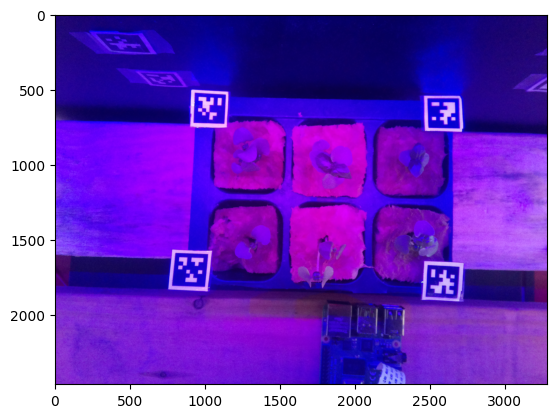

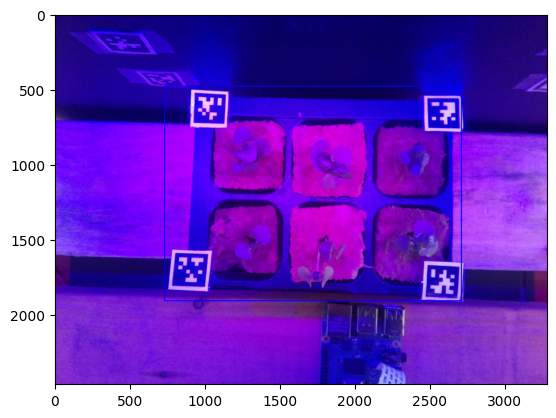

In [59]:
import image_helper
dt_str = '3/12/2022 19:08:18'
dt = im_helper.dt_from_string(dt_str)
assert(im_helper.get(dt, "top"))
img, path, filename = pcv.readimage(im_helper.image.name)
crop_img = pcv.crop(img=img, x=730, y=480, h=1430, w=1980)

In [62]:
def filter(crop_img):
    corrected_img = pcv.white_balance(img=crop_img, mode='hist', roi=[280, 120, 5, 5])
    rotate_img = pcv.transform.rotate(corrected_img, 2, True)
    gray_img = pcv.rgb2gray_lab(rgb_img=rotate_img, channel='b')
    return gray_img

def create_mask(gray_img):
    thresh = pcv.threshold.binary(gray_img=gray_img, threshold=55, max_value=255, object_type='dark')
    rois, roi_hierarchy = pcv.roi.multi(img=a, coord=(550,460), radius=180, 
                                    spacing=(550, 580), nrows=2, ncols=3)
    roi_mask = pcv.roi.roi2mask(img=gray_img, contour=rois[0])
    for r in rois:
        new_mask = pcv.roi.roi2mask(img=gray_img, contour=r)
        roi_mask = np.maximum(roi_mask, new_mask)
    combined_mask = np.minimum(roi_mask, thresh)
    filled_mask = pcv.fill(bin_img=combined_mask, size=200)
    pcv.plot_image(filled_mask)
    return filled_mask


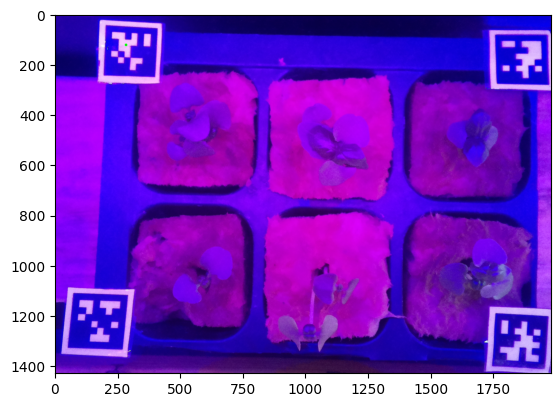

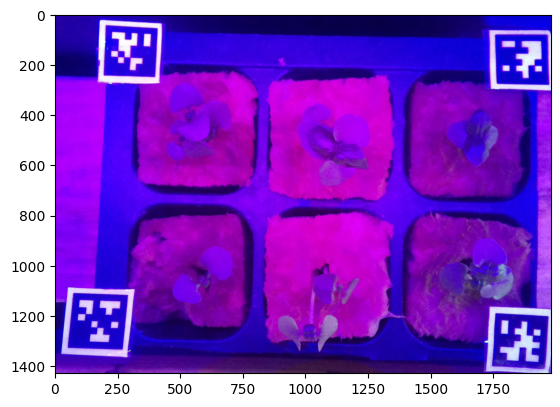

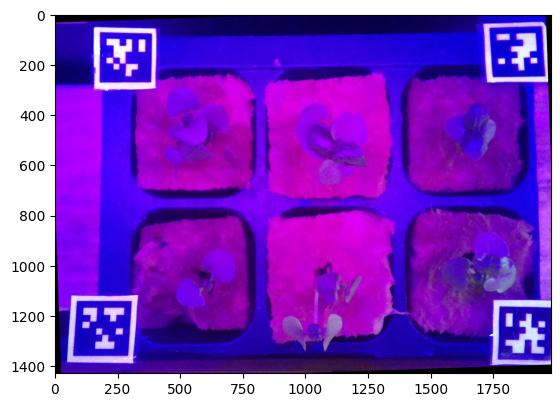

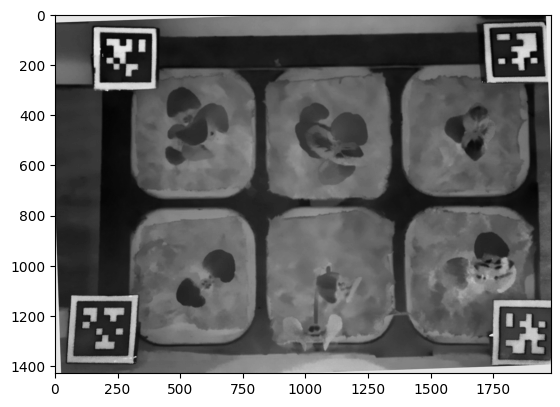

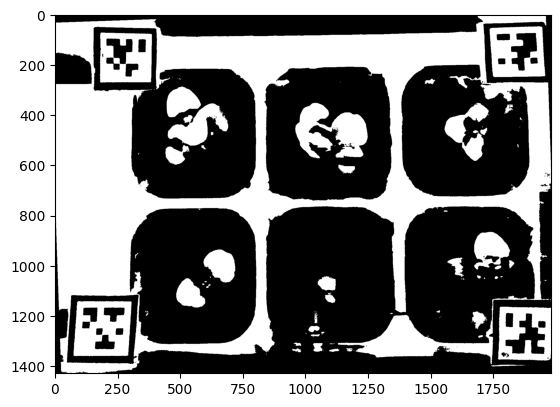

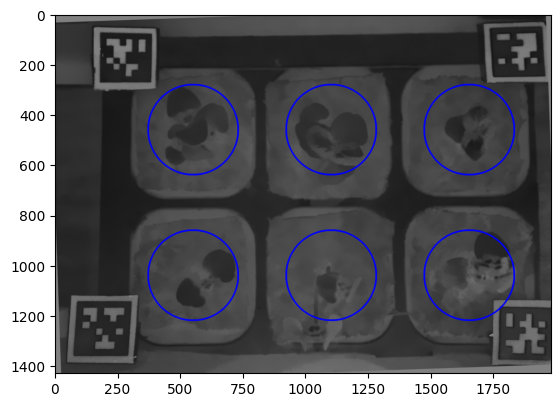

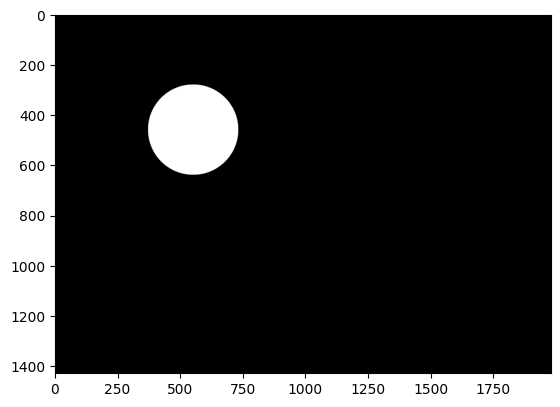

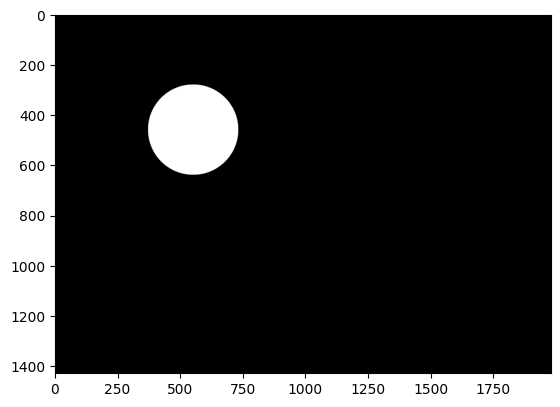

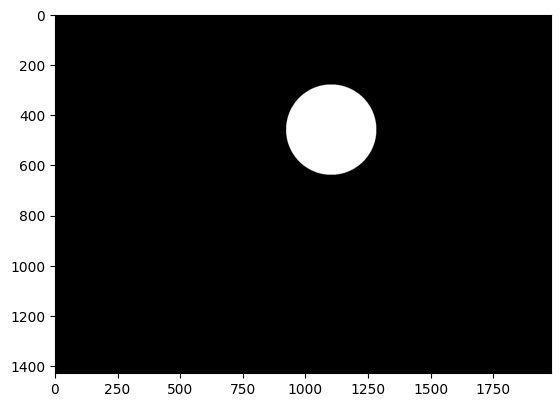

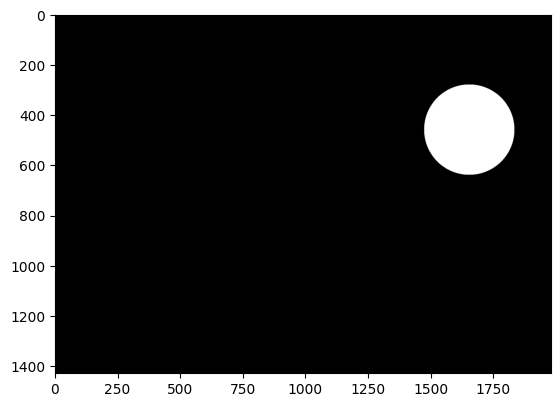

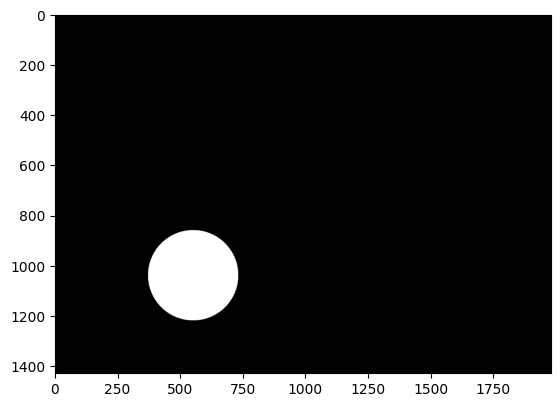

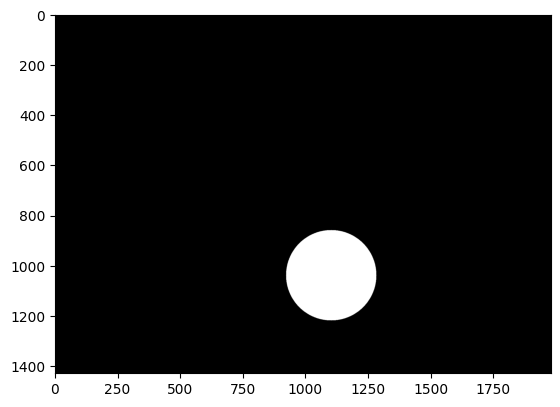

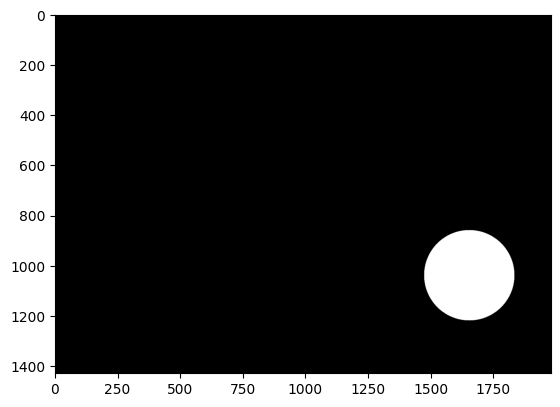

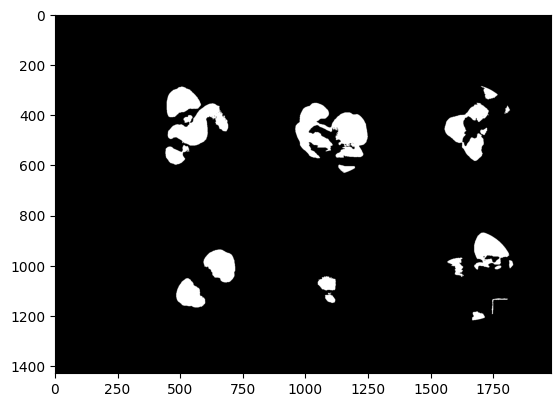

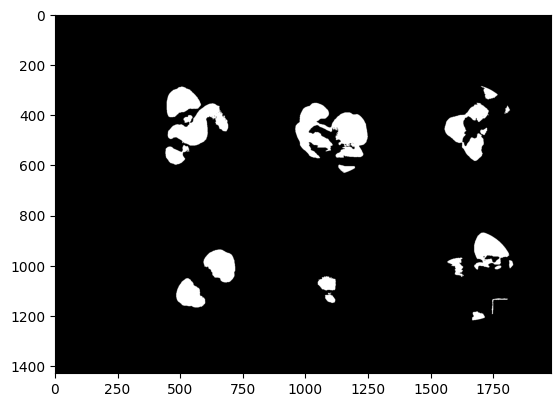

In [63]:
gray_img = filter(crop_img)
mask = create_mask(gray_img)

In [ ]:
# Create a copy of the original image for annotations

# Inputs:
#   img = rgb image
img_copy = np.copy(img)

# Set debug to None (plotting all of the images would be very verbose output)
pcv.params.debug = None

# Create a for loop to interate through every ROI (plant) in the image
for i in range(0, len(rois)):
    # The ith ROI, ROI hierarchy, and plant ID
    roi = rois[i]
    hierarchy = roi_hierarchy[i]
    plant_id = plant_ids[i]
    # Subset objects that overlap the ROI
    # Inputs:
    #   img            = input image
    #   roi_contour    = a single ROI contour
    #   roi_hierarchy  = a single ROI hierarchy
    #   object_contour = all objects detected in a binary mask
    #   obj_hierarchy  = all object hierarchies
    #   roi_type       = "partial" (default) keeps contours that overlap
    #                    or are contained in the ROI. "cutto" cuts off
    #                    contours that fall outside the ROI. "largest"
    #                    only keeps the largest object within the ROI
    plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=img, 
                                                                  roi_contour=roi, 
                                                                  roi_hierarchy=hierarchy, 
                                                                  object_contour=obj, 
                                                                  obj_hierarchy=obj_hierarchy, 
                                                                  roi_type="partial")

    # If the plant area is zero then no plant was detected for the ROI
    # and no measurements can be done
    if area > 0:
        # Combine contours together for each plant
        # Inputs:
        #   img       = input image
        #   contours  = contours that will be consolidated into a single object
        #   hierarchy = the relationship between contours
        plant_obj, plant_mask = pcv.object_composition(img=img, 
                                                       contours=plant_contours, 
                                                       hierarchy=plant_hierarchy)        
        # Analyze the shape of each plant
        # Inputs:
        #   img   = input image
        #   obj   = composed object contours
        #   mask  = binary mask that contours were derived from
        #   label = a label for the group of measurements (default = "default")
        img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                      mask=plant_mask, label=f"plant{plant_id}")

pcv.plot_image(img_copy)

In [64]:
import cv2
import numpy as np
# proccess image
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# get threshold image
ret, thresh_img = cv2.threshold(img_grey, 100, 255, cv2.THRESH_BINARY)
# find contours
contours, hierarchy = cv2.findContours(
    thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)

# create an empty image for contours
img_contours = np.zeros(img.shape)

max_contour = contours[0]
for contour in contours:
    if (
        cv2.contourArea(contour) > cv2.contourArea(max_contour)
        and cv2.contourArea(contour) < 100000
    ):
        max_contour = contour

contour = max_contour
approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
x, y, w, h = cv2.boundingRect(approx)

square_area = (x - w) * (y - h)
